### Installing Required Packages

In [1]:
!pip install pandas
!pip install numpy
!pip install statsmodels
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

### Importing Packages

In [2]:
# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# main
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 500)

In [3]:
# reading data
data = pd.read_csv('./data.csv')
data

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,R,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,R,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,R,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,R,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,R,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,643361,R,FB,NaN,StrikeCalled,15.72580,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,643361,R,CF,NaN,BallCalled,10.86980,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,643361,R,FB,NaN,FoulBall,14.10840,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,643361,R,CH,double,InPlay,10.49140,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


### Addressing Pitcher Handedness

Need to even the Pitcher Handedness to keep the pitches consistent from a right-handed pitcher
###### Attributes affected by handedness are,
- HORIZONTAL_BREAK
- RELEASE_SIDE
- HORIZONTAL_APPROACH_ANGLE

To handle this I will flip the sign for the above attributes for Left handed pitchers.

In [4]:
data['THROW_SIDE_KEY'].value_counts()

R    7268
L    2621
Name: THROW_SIDE_KEY, dtype: int64

In [5]:
data['HORIZONTAL_BREAK'] = data.apply(lambda x: -x['HORIZONTAL_BREAK'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_BREAK'], axis=1)
data['RELEASE_SIDE'] = data.apply(lambda x: -x['RELEASE_SIDE'] if x['THROW_SIDE_KEY'] == 'L' else x['RELEASE_SIDE'], axis=1)
data['HORIZONTAL_APPROACH_ANGLE'] = data.apply(lambda x: -x['HORIZONTAL_APPROACH_ANGLE'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_APPROACH_ANGLE'], axis=1)
data = data.drop(columns="THROW_SIDE_KEY")

In [6]:
data.isna().sum()

PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

### Treating Pitchers and Pitch Types as Random Effects

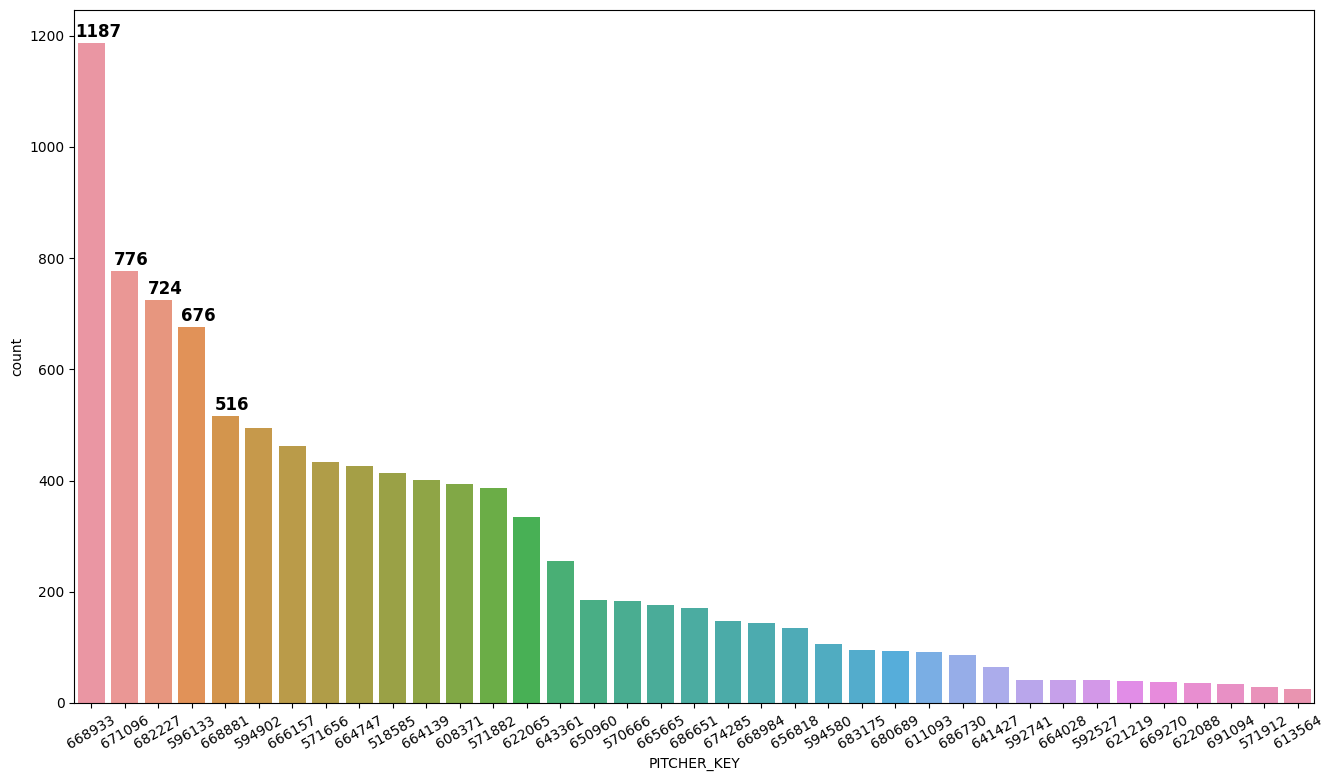

In [7]:
# plot to show different number of pitchers
fig_pitcher, ax_pitcher = plt.subplots(figsize=(16,9))
sns.countplot(data, x="PITCHER_KEY", ax=ax_pitcher, order=data['PITCHER_KEY'].value_counts().index)
plt.xticks(rotation=30)
for index, value in enumerate(data['PITCHER_KEY'].value_counts()[0:5]):
    label = '{}'.format(value)
    ax_pitcher.annotate(label,
                xy=(index+0.2, value+20),
                ha='center',
                va='center',
                fontweight='bold',
                size=12)
plt.show()

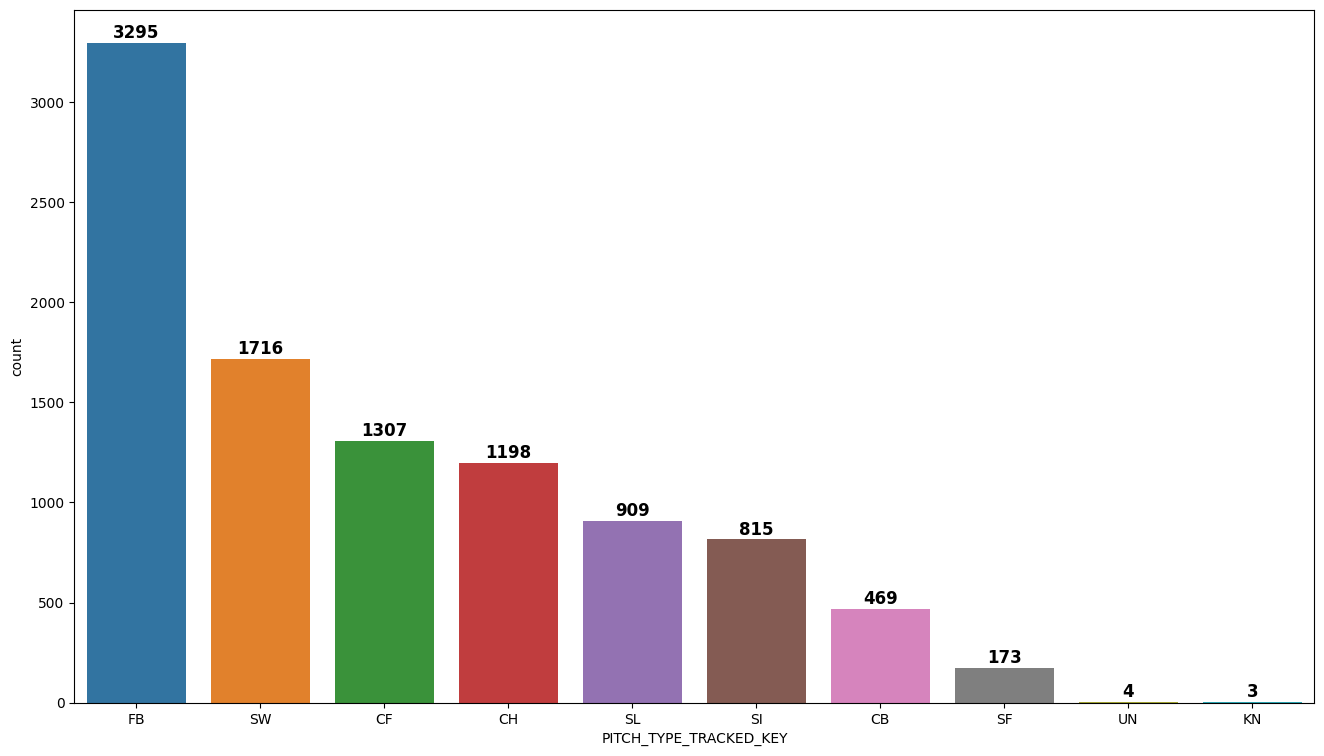

In [8]:
# plot to show different types of pitches and quantity
fig_pitches, ax_pitches = plt.subplots(figsize=(16,9))
sns.countplot(data, x="PITCH_TYPE_TRACKED_KEY", ax=ax_pitches, order=data['PITCH_TYPE_TRACKED_KEY'].value_counts().index)
for index, value in enumerate(data['PITCH_TYPE_TRACKED_KEY'].value_counts()):
    label = '{}'.format(value)
    ax_pitches.annotate(label,
                xy=(index, value+50),
                ha='center',
                va='center',
                fontweight='bold',
                size=12)
plt.show()

##### Removing UN and KN since 7 rows combined

In [9]:
# since there are 7 pitches that are tagged Unknown and Knuckleball, I have decided to remove them.
data = data[~((data['PITCH_TYPE_TRACKED_KEY']=='UN') | (data['PITCH_TYPE_TRACKED_KEY']=='KN'))]
data

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,643361,FB,NaN,StrikeCalled,15.72580,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,643361,CF,NaN,BallCalled,10.86980,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,643361,FB,NaN,FoulBall,14.10840,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,643361,CH,double,InPlay,10.49140,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


### Checking Potential Outliers

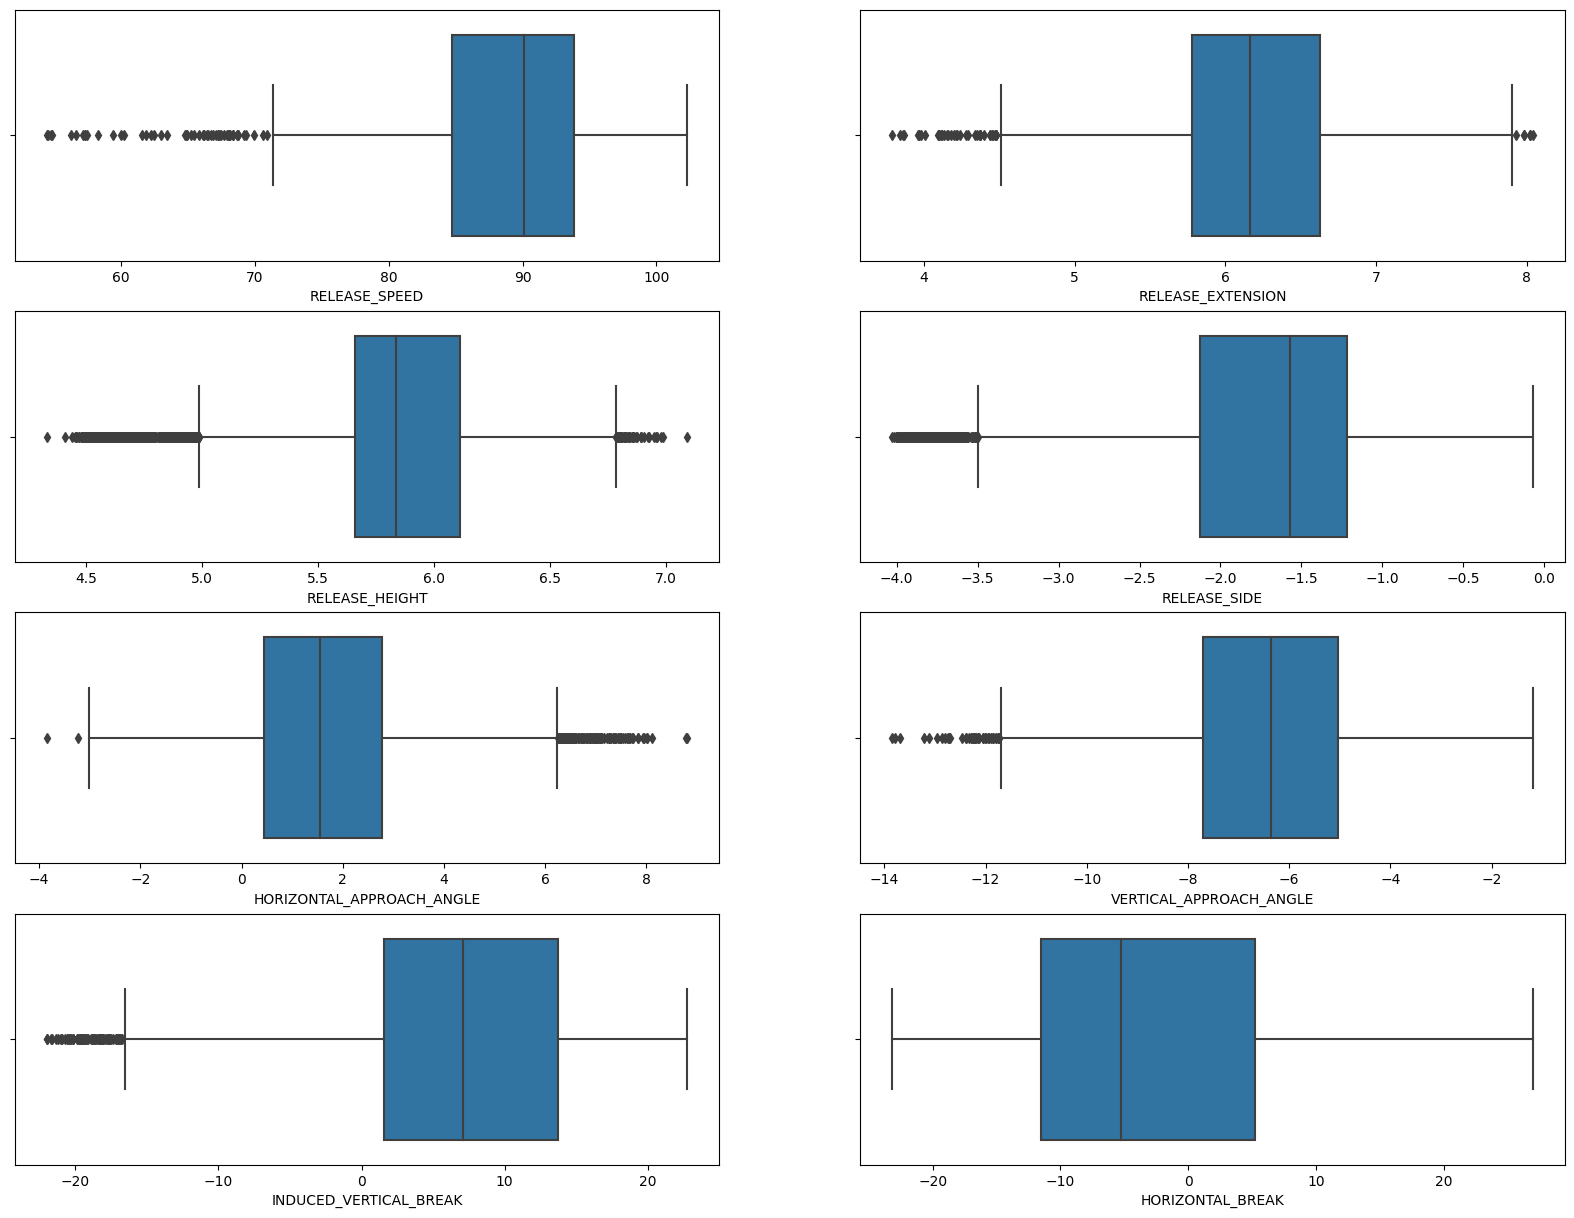

In [10]:
# box plot to look for outliers, followed by describe method
fig_pchar, ax_pchar = plt.subplots(4,2,figsize=(20,15))
sns.boxplot(data, x="RELEASE_SPEED", ax=ax_pchar[0][0])
sns.boxplot(data, x="RELEASE_EXTENSION", ax=ax_pchar[0][1])
sns.boxplot(data, x="RELEASE_HEIGHT", ax=ax_pchar[1][0])
sns.boxplot(data, x="RELEASE_SIDE", ax=ax_pchar[1][1])
sns.boxplot(data, x="HORIZONTAL_APPROACH_ANGLE", ax=ax_pchar[2][0])
sns.boxplot(data, x="VERTICAL_APPROACH_ANGLE", ax=ax_pchar[2][1])
sns.boxplot(data, x="INDUCED_VERTICAL_BREAK", ax=ax_pchar[3][0])
sns.boxplot(data, x="HORIZONTAL_BREAK", ax=ax_pchar[3][1])
plt.show()

##### Looking at Low Release Speeds (potential Position players)

In [11]:
data[data['RELEASE_SPEED']<70].groupby('PITCHER_KEY')['PITCH_TYPE_TRACKED_KEY'].value_counts()

PITCHER_KEY  PITCH_TYPE_TRACKED_KEY
571912       FB                        23
613564       FB                        25
621219       CB                         3
682227       CB                         1
Name: PITCH_TYPE_TRACKED_KEY, dtype: int64

In [12]:
data[data['RELEASE_SPEED']<75].groupby('PITCHER_KEY')['RELEASE_SPEED'].mean()

PITCHER_KEY
571882    74.915348
571912    67.870132
592527    74.433899
594902    74.475957
613564    60.212256
621219    67.533033
643361    74.701599
682227    72.762039
Name: RELEASE_SPEED, dtype: float64

##### Removing the keys 571912 and 613564 due to their avg FB speed being 67 & 69mph

In [13]:
data = data[~((data['PITCHER_KEY']==571912)|(data['PITCHER_KEY']==613564))]
data

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,643361,FB,NaN,StrikeCalled,15.72580,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,643361,CF,NaN,BallCalled,10.86980,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,643361,FB,NaN,FoulBall,14.10840,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,643361,CH,double,InPlay,10.49140,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


##### New box plots

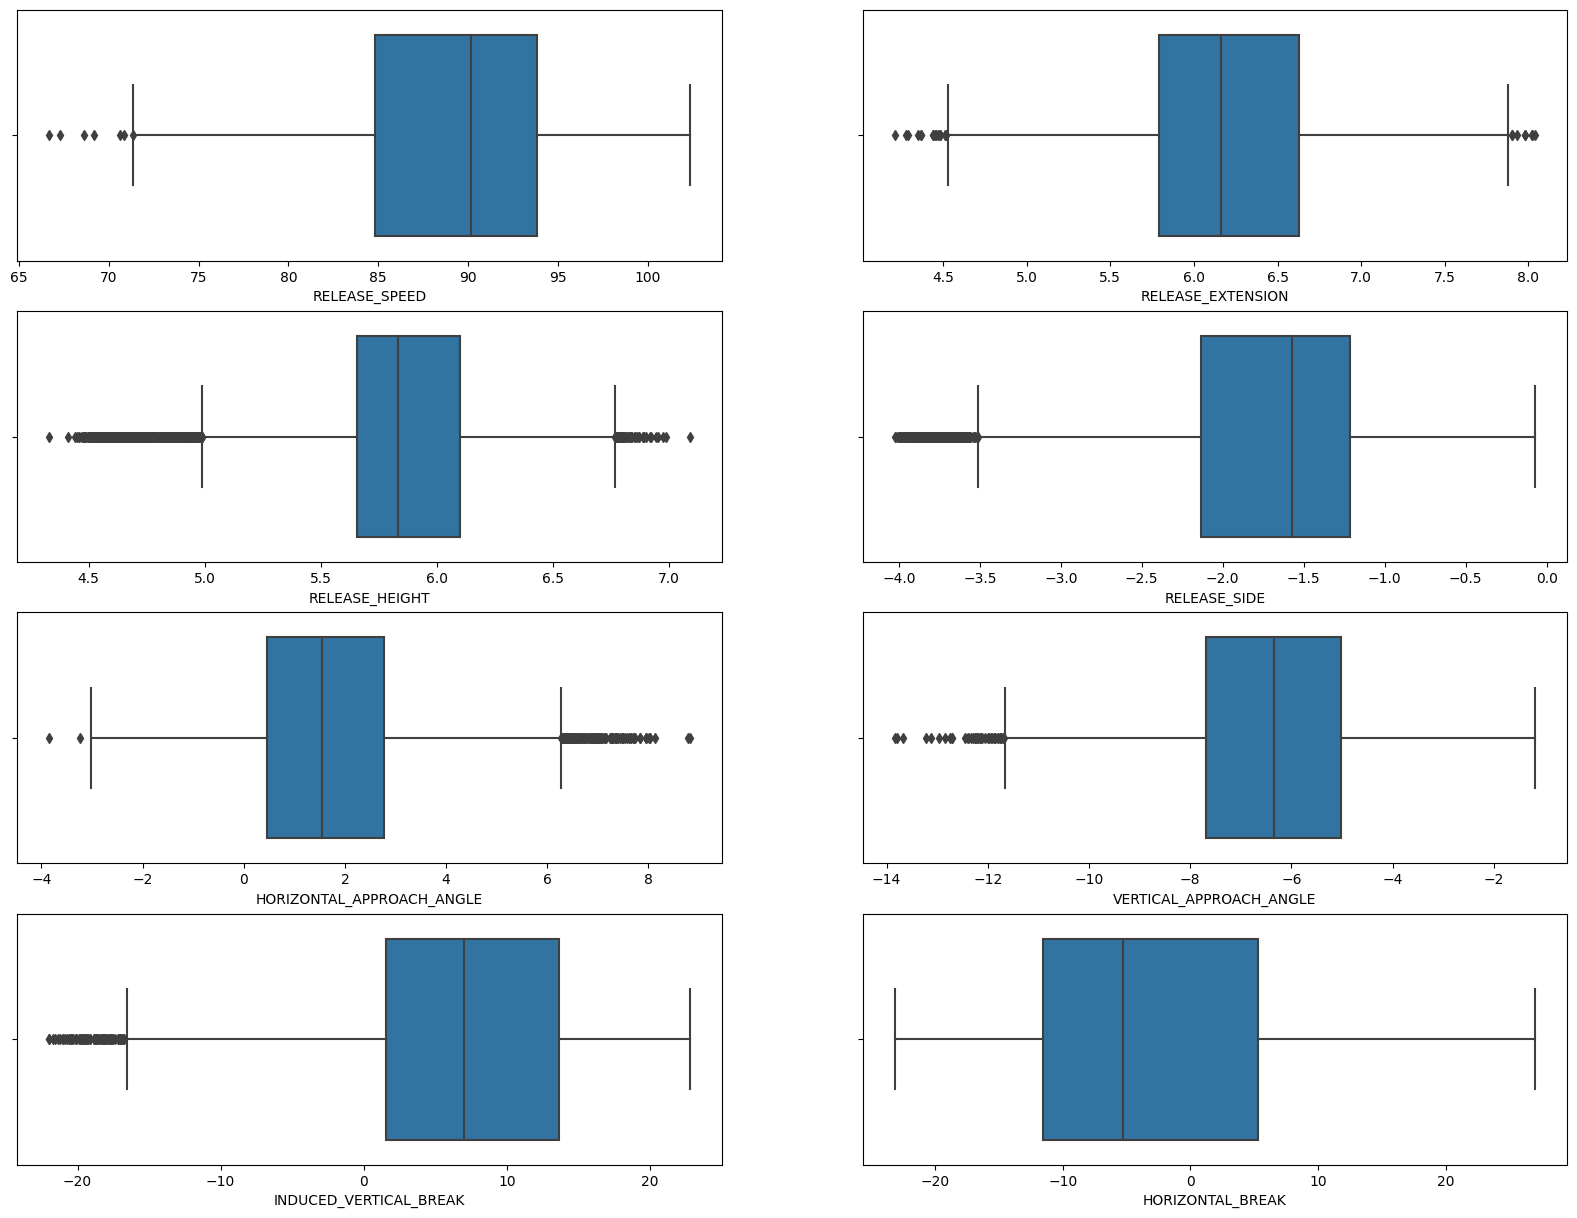

In [14]:
# box plot to look for outliers, followed by describe method
fig_pchar, ax_pchar = plt.subplots(4,2,figsize=(20,15))
sns.boxplot(data, x="RELEASE_SPEED", ax=ax_pchar[0][0])
sns.boxplot(data, x="RELEASE_EXTENSION", ax=ax_pchar[0][1])
sns.boxplot(data, x="RELEASE_HEIGHT", ax=ax_pchar[1][0])
sns.boxplot(data, x="RELEASE_SIDE", ax=ax_pchar[1][1])
sns.boxplot(data, x="HORIZONTAL_APPROACH_ANGLE", ax=ax_pchar[2][0])
sns.boxplot(data, x="VERTICAL_APPROACH_ANGLE", ax=ax_pchar[2][1])
sns.boxplot(data, x="INDUCED_VERTICAL_BREAK", ax=ax_pchar[3][0])
sns.boxplot(data, x="HORIZONTAL_BREAK", ax=ax_pchar[3][1])
plt.show()

In [15]:
data.describe()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
count,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000,9831.000000
mean,12645.862069,4.985454,2.935815,2.881904,0.998881,0.884142,0.875598,0.309124,0.173838,0.101821,637699.332825,6.877742,-2.740236,2297.552968,89.282883,-1.724109,5.822326,6.233342,1.700410,-6.401532,0.073171,2.336383
std,7799.810427,2.651799,1.742197,1.715405,0.822186,0.965479,0.822673,0.462156,0.378989,0.302428,44884.398632,7.729233,10.840579,375.214272,5.627576,0.755182,0.458726,0.551836,1.694808,1.822700,0.822985,0.975562
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518585.000000,-21.982201,-23.168800,524.210999,66.687302,-4.026390,4.330060,4.210000,-3.847480,-13.842500,-3.588650,-1.892670
25%,6024.500000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,596133.000000,1.545145,-11.543300,2136.484985,84.840599,-2.134035,5.656995,5.790000,0.452239,-7.681820,-0.479814,1.686955
50%,12633.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,664747.000000,7.007230,-5.254030,2324.469971,90.149200,-1.571090,5.833540,6.160000,1.548290,-6.354580,0.073673,2.337760
75%,19554.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,668933.000000,13.636100,5.257600,2505.484985,93.845848,-1.215795,6.102255,6.630000,2.779205,-5.021065,0.622613,2.999535
max,28755.000000,11.000000,14.000000,14.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,691094.000000,22.767300,26.991199,3314.679932,102.327003,-0.071233,7.090960,8.040000,8.813830,-1.185400,3.983160,6.079330


### Data Selection and Model Building

In [16]:
data = data.loc[:,['PID', 'PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY', 'SPIN_RATE_ABSOLUTE',
       'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE','INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK']]
data

,PID,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
0,197,668881,FB,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,14.54220,-12.36030
1,348,668881,FB,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,14.25380,-10.95030
2,1072,668881,SL,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,5.56877,4.35335
3,420,668881,SL,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,4.80541,4.27254
4,198,668881,SL,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,4.13239,1.62418
...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,643361,FB,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,15.72580,-8.54239
9885,28642,643361,CF,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,10.86980,0.60670
9886,22664,643361,FB,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,14.10840,-10.84110
9887,22665,643361,CH,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,10.49140,-13.44000


Just keeping pitch characteristics (fixed effects) that may affect Induced Vertical Break and Horizontal Break. For random effect, we can take the Pitcher ID and the Pitch Type in context.

With a threshold of 0.6, 
- Vertical Approach Angle - Release Speed => highly correlated  

<br>

- Induced Vertical Break Model
    - Removed Release Speed rather than Vertical Approach Angle
- Horizontal Break Model
    - Removed Vertical Approach Angle rather than Release Speed

In [17]:
display(data.corr())
def high_corr_pairs(df, threshold=0.8):
    """
    Identify pairs of variables in a DataFrame that have a correlation coefficient above a specified threshold.
    
    Parameters:
    - df (DataFrame): The input data.
    - threshold (float, optional): The correlation coefficient threshold. Defaults to 0.8.
    
    Returns:
    - list of tuples: Pairs of column names with high correlation.
    """
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    pairs = []
    for column in to_drop:
        above_threshold_vars = upper.index[upper[column] > threshold].tolist()
        for atv in above_threshold_vars:
            pairs.append((column, atv))

    return pairs

high_corr_pairs(data, threshold=0.6)

,PID,PITCHER_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
PID,1.000000,0.108746,0.006415,0.008507,0.221509,0.003201,0.027265,-0.080007,0.043261,0.019736,0.065201
PITCHER_KEY,0.108746,1.000000,0.248474,0.148756,-0.237286,0.040599,0.027668,0.132120,0.043000,-0.003690,0.049950
SPIN_RATE_ABSOLUTE,0.006415,0.248474,1.000000,0.040228,-0.109316,-0.019736,-0.166269,0.523205,-0.046325,-0.145530,0.575978
RELEASE_SPEED,0.008507,0.148756,0.040228,1.000000,0.045998,0.098236,-0.020267,-0.380661,0.691127,0.719582,-0.486248
RELEASE_SIDE,0.221509,-0.237286,-0.109316,0.045998,1.000000,0.457217,-0.171425,-0.384783,-0.047240,0.083390,0.111178
RELEASE_HEIGHT,0.003201,0.040599,-0.019736,0.098236,0.457217,1.000000,-0.506256,-0.138715,-0.222843,-0.016746,0.106837
RELEASE_EXTENSION,0.027265,0.027668,-0.166269,-0.020267,-0.171425,-0.506256,1.000000,0.020898,0.177075,0.147325,-0.116992
HORIZONTAL_APPROACH_ANGLE,-0.080007,0.132120,0.523205,-0.380661,-0.384783,-0.138715,0.020898,1.000000,-0.397760,-0.418500,0.732511
VERTICAL_APPROACH_ANGLE,0.043261,0.043000,-0.046325,0.691127,-0.047240,-0.222843,0.177075,-0.397760,1.000000,0.801221,-0.435673
INDUCED_VERTICAL_BREAK,0.019736,-0.003690,-0.145530,0.719582,0.083390,-0.016746,0.147325,-0.418500,0.801221,1.000000,-0.518992


[('VERTICAL_APPROACH_ANGLE', 'RELEASE_SPEED'),
 ('INDUCED_VERTICAL_BREAK', 'RELEASE_SPEED'),
 ('INDUCED_VERTICAL_BREAK', 'VERTICAL_APPROACH_ANGLE'),
 ('HORIZONTAL_BREAK', 'HORIZONTAL_APPROACH_ANGLE')]

In [18]:
# class Model to implement the mixed effect modeling
class Model:
    def __init__(self, formula, data):
        """
        Initializes the Model class.
        
        Parameters:
        - formula (str): A Patsy-compatible formula representing the fixed-effects relationship.
        - data (DataFrame): The data to be used for model estimation.
        """
        self.data = data
        self.formula = formula

    def scale_data(self, dummy):
        """
        Scales the non-categorical columns in the dataset to have zero mean and unit variance.
        
        Parameters:
        - dummy (DataFrame): A dataframe containing only the columns to be scaled.
        """
        scaler = StandardScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(dummy), columns=self.data.iloc[:,3:].columns)
        self.data = pd.concat([self.data.iloc[:,:3],scaled_data], axis=1)

    def build_model(self, *group_col):
        """
        Builds the mixed linear model. Can handle either single or nested groupings.
        
        Parameters:
        - *group_col (str): Names of the grouping columns.
        """
        # For single grouping
        if len(group_col) == 1:
            self.model = smf.mixedlm(self.formula, self.data, groups=self.data[group_col[0]]).fit()
        # For nested grouping
        elif len(group_col) == 2:
            # Create combined grouping variable for nested grouping if either is a string column
            if self.data[group_col[0]].dtypes == object or self.data[group_col[1]].dtypes == object:
                self.data[group_col[0] + '_' + group_col[1]] = str(self.data[group_col[0]]) + '_' + str(self.data[group_col[1]])
            self.model = smf.mixedlm(self.formula, self.data, groups=self.data[group_col[0] + '_' + group_col[1]]).fit()

    def get_summary(self):
        """
        Returns the summary of the fitted mixed linear model.
        """
        return self.model.summary()

    def get_residuals(self):
        """
        Computes and returns the residuals of the model.
        """
        self.data['residuals'] = self.model.resid
        return self.model.resid

    def get_predictions(self, new_data=None):
        """
        Predicts based on the mixed linear model.

        Parameters:
        - new_data (DataFrame, optional): Data on which predictions are to be made. If None, predictions are made on the training data.

        Returns:
        - array: Predictions.
        """
        if new_data is None:
            return self.model.predict(self.data)
        else:
            return self.model.predict(new_data)

    def compute_prob(self):
        """
        Computes the probability that each observation was affected by an unobserved factor.
        
        Returns:
        - DataFrame: Contains the 'PID' and 'prob_affected' for each observation.
        """
        mean_resid = np.mean(self.data['residuals'])
        std_resid = np.std(self.data['residuals'])

        def get_prob_affected(residual,mean_resid,std_resid):
            """
            Computes probability of external factor involvement
            
            Returns:
            - float: Probability Affected
            """
            #Compute the probability for extreme values based on residual's sign
            if residual < 0:
                prob_affected = 1 - norm.cdf(residual, mean_resid, std_resid)
            else:
                prob_affected = norm.cdf(residual, mean_resid, std_resid)
                
            return prob_affected
                
        self.data['prob_affected'] = [get_prob_affected(res,mean_resid,std_resid) for res in self.data['residuals']]
        
        return self.data[['PID', 'prob_affected']]
    

    def plot_resid(self):
        """
        Plots the distribution of residuals and a QQ-plot to assess model fit.
        """
        fig, axs = plt.subplots(2, figsize=(16, 9))
        sns.kdeplot(self.model.resid, fill=True, common_norm=True, ax=axs[0])
        sm.qqplot(self.model.resid, dist=norm, line='s', ax=axs[1])
        plt.show()

    def calc_rmse(self):
        """
        Calculates the root mean squared error (RMSE) for the model.
        
        Returns:
        - float: RMSE.
        """
        error = self.get_residuals()
        squared_errors = np.square(error)
        mean_squared_error = np.mean(squared_errors)
        return np.sqrt(mean_squared_error)

4.317968354201199
                  Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  INDUCED_VERTICAL_BREAK
No. Observations:    9831     Method:              REML                  
No. Groups:          1        Scale:               18.6581               
Min. group size:     9831     Log-Likelihood:      -28350.4045           
Max. group size:     9831     Converged:           Yes                   
Mean group size:     9831.0                                              
-------------------------------------------------------------------------
                          Coef.    Std.Err.      z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                  6.405        4.504   1.422 0.155 -2.423 15.232
SPIN_RATE_ABSOLUTE        -0.002        0.000 -10.958 0.000 -0.002 -0.001
RELEASE_SIDE               0.373        0.071   5.235 0.000  0.233  0.512
RELEASE_HEIGHT             3.264      

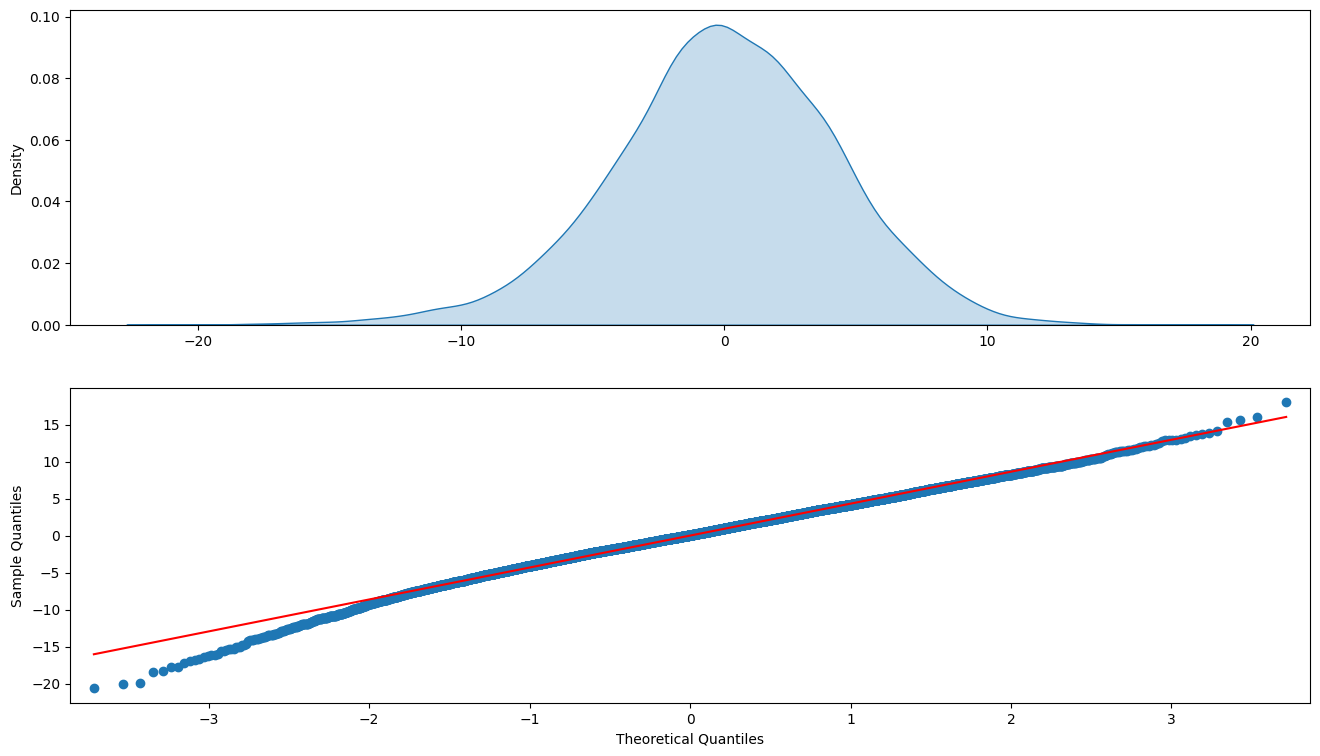

,PID,prob_affected
0,197,0.861798
1,348,0.539236
2,1072,0.540546
3,420,0.557192
4,198,0.875554
...,...,...
9884,22663,0.657958
9885,28642,0.521874
9886,22664,0.802141
9887,22665,0.865362


In [19]:
vertical_break = Model("INDUCED_VERTICAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SIDE + RELEASE_HEIGHT + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE", data)
#vertical_break.scale_data(data.iloc[:,3:])
#vertical_break.build_model("PITCHER_KEY")
vertical_break.build_model("PITCHER_KEY","PITCH_TYPE_TRACKED_KEY")
print(vertical_break.calc_rmse())
print(vertical_break.get_summary())
print(vertical_break.get_residuals())
vertical_break.plot_resid()
prob_vertical = vertical_break.compute_prob()
display(prob_vertical)

4.693461830246344
                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    HORIZONTAL_BREAK
No. Observations:      9831       Method:                REML            
No. Groups:            1          Scale:                 22.0443         
Min. group size:       9831       Log-Likelihood:        -29170.7419     
Max. group size:       9831       Converged:             Yes             
Mean group size:       9831.0                                            
-------------------------------------------------------------------------
                          Coef.    Std.Err.      z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                 18.459        4.923   3.749 0.000  8.810 28.108
SPIN_RATE_ABSOLUTE         0.009        0.000  55.847 0.000  0.009  0.009
RELEASE_SPEED             -0.560        0.010 -57.169 0.000 -0.579 -0.541
RELEASE_SIDE               5.235      

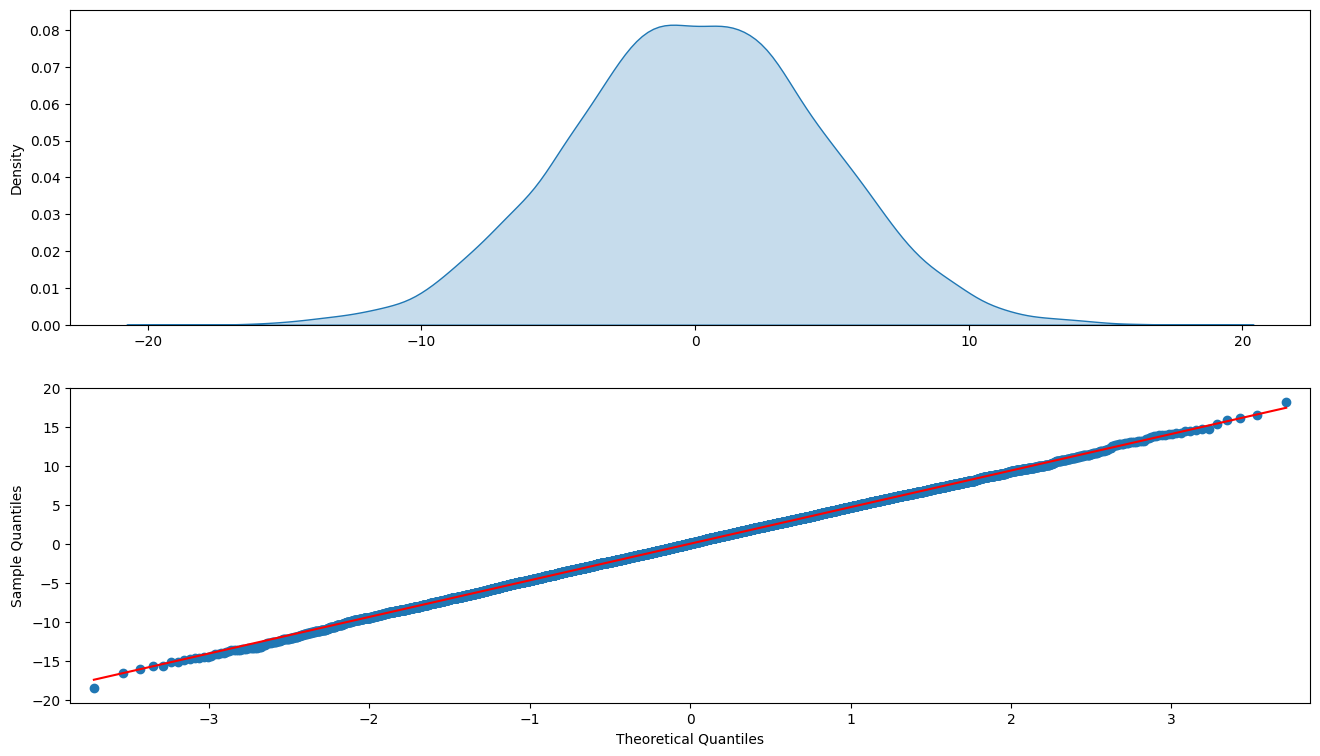

,PID,prob_affected
0,197,0.549053
1,348,0.909475
2,1072,0.879886
3,420,0.719902
4,198,0.844348
...,...,...
9884,22663,0.754837
9885,28642,0.562237
9886,22664,0.684169
9887,22665,0.840237


In [20]:
horizontal_break = Model("HORIZONTAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SPEED + RELEASE_SIDE + RELEASE_HEIGHT + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE", data)
#horizontal_break.scale_data(data.iloc[:,3:])
#horizontal_break.build_model("PITCHER_KEY")
horizontal_break.build_model("PITCHER_KEY","PITCH_TYPE_TRACKED_KEY")
print(horizontal_break.calc_rmse())
print(horizontal_break.get_summary())
print(horizontal_break.get_residuals())
horizontal_break.plot_resid()
prob_horizontal = horizontal_break.compute_prob()
display(prob_horizontal)

In [21]:
data['prob_affected'] = (prob_vertical['prob_affected'] + prob_horizontal['prob_affected'])/2
final_prob = data[['PID','prob_affected']]
final_prob

,PID,prob_affected
0,197,0.705426
1,348,0.724355
2,1072,0.710216
3,420,0.638547
4,198,0.859951
...,...,...
9884,22663,0.706398
9885,28642,0.542055
9886,22664,0.743155
9887,22665,0.852799


In [22]:
final_prob.to_csv('submission.csv',index=False)